# Monthly Cross-Section: Estimation

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot
import mypack.clas as clas

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Data

Data is imported from [Kenneth French's data library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and [FRED](https://fred.stlouisfed.org/series/). Currently, this workbook uses 49 industry portfolios and the FF3 factors. Additionally, NBER recession indicators complement the data.

In [6]:
#sample_start = dt.datetime(1962,1,1)
sample_start = dt.datetime(1900,1,1)
sample_end = dt.datetime(2019,9,30)

### Factor data

In [7]:
#factors_daily = data.download_factor_data('D')/100
#factors_monthly = data.download_factor_data('M')/100

#factors_daily = factors_daily.loc[(factors_daily.index >= sample_start) & (factors_daily.index <= sample_end)]
#factors_monthly = factors_monthly.loc[(factors_monthly.index >= sample_start) & (factors_monthly.index <= sample_end)]

### Industry data

In [8]:
industries_daily = data.download_industry_data('D', excessreturns=True)/100
industries_monthly = data.download_industry_data('M', excessreturns=True)/100

In [9]:
industries_daily = industries_daily.loc[(industries_daily.index >= sample_start) & (industries_daily.index <= sample_end)]
industries_monthly = industries_monthly.loc[(industries_monthly.index >= sample_start) & (industries_monthly.index <= sample_end)]

### Recession data

In [10]:
#usrec_daily = data.download_recessions_data('D')
#usrec_monthly = data.download_recessions_data('M')

## Estimation
### Setup

In [11]:
df_xs_estimates = pd.DataFrame(industries_monthly.stack().rename(('data','return')))

In [12]:
#df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly.pkl')

### Define outputs

In [13]:
def get_moment_vector(y):
    '''
    This function defines a vector that contains the first four moments of y
    '''
    moment_vector = \
        pd.Series([y.mean(), y.std(), y.var(), y.skew(),y.kurtosis()], index=['mean','std','var','skew','exkurt'])
    return moment_vector

In [14]:
def get_hmm_model_output(hmm_model): # TO DO: Make suitable for more states
    '''
    This function defines a vector with estimates from a hidden markov model object
    '''
    model_output = \
        pd.Series([hmm_model.mle_retvals['converged'],algo,hmm_model.nobs,hmm_model.aic,hmm_model.bic,hmm_model.llf],index=['convergence','algorithm','T','aic','bic','likelihood'])\
            .append(pd.Series(hmm_model.params.values,index=['p00','p10','mu_0','mu_1','sigma2_0','sigma2_1']))\
            .append(pd.Series(hmm_model.bse.values,index=['p00_se','p10_se','mu_0_se','mu_1_se','sigma2_0_se','sigma2_1_se']))\
            .append(pd.Series(hmm_model.cov_params().loc['const[0]','const[1]'],index=['mu_cov']))\
            .append(pd.Series(hmm_model.cov_params().loc['sigma2[0]','sigma2[1]'],index=['sigma_cov']))\
            .append(pd.Series(hmm_model.cov_params().loc['p[0->0]','p[1->0]'],index=['prob_cov']))\
            .append(pd.Series(hmm_model.smoothed_marginal_probabilities.iloc[-1,:].values,index=['smooth_prob_0','smooth_prob_1']))\
            .append(pd.Series(hmm_model.filtered_marginal_probabilities.iloc[-1,:].values,index=['filt_prob_0','filt_prob_1']))\
            .append(pd.Series(hmm_model.smoothed_marginal_probabilities.mean().values,index=['mean_smooth_prob_0','mean_smooth_prob_1']))\
            .append(pd.Series(hmm_model.filtered_marginal_probabilities.mean().values,index=['mean_filt_prob_0','mean_filt_prob_1']))\
            .append(pd.Series(abs(hmm_model.smoothed_marginal_probabilities.iloc[-1,:]-hmm_model.smoothed_marginal_probabilities.iloc[-2,:]).mean(),index=['smooth_prob_innov']))\
            .append(pd.Series(abs(hmm_model.filtered_marginal_probabilities.iloc[-1,:]-hmm_model.filtered_marginal_probabilities.iloc[-2,:]).mean(),index=['filt_prob_innov']))
    return model_output

In [15]:
def get_state_probabilities(hmm_model):
    '''
    This is to extract the in-sample state probabilities
    '''
    state_probs = \
        pd.DataFrame(hmm_model.smoothed_marginal_probabilities.values, index=hmm_model.smoothed_marginal_probabilities.index, columns=['smooth_is_0','smooth_is_1'])\
            .join(pd.DataFrame(hmm_model.filtered_marginal_probabilities.values, index=hmm_model.smoothed_marginal_probabilities.index, columns=['filt_is_0','filt_is_1']))
    return state_probs

### Full Sample
#### Names

In [16]:
hmm_name = 'HMM_full'
moment_name = 'moment_full'

In [17]:
algos = ['powell','ncg','bfgs','cg','newton']

#### Run

In [18]:
%%time
count = 0
full_sample_estimates = pd.DataFrame([])

for name,data in tqdm.tqdm(industries_monthly.items()):
    
    # calculate sample moments
    moment_vector = get_moment_vector(data)
    
    # treat outliers
    y = pd.Series(data.values,index=data.index).copy()
    m,s = moment_vector[['mean','std']]
    y[y<m-2.325*s] = m-2.325*s + 0.1*(y[y<m-2.325*s]-(m-2.325*s))
    y[y>m+2.325*s] = m+2.325*s + 0.1*(y[y>m-2.325*s]-(m+2.325*s))
    
    # set initial guesses for parameters
    init = [0.9,0.1] + [m] + [m] + [(2*s)**2] + [(0.5*s)**2]
    
    # estimate model
    for algo in algos:
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore")
            hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=init, method=algo, disp=False)
        if (not any(hmm_model.params.isna())):
            break
            
    # outputs
    model_output = get_hmm_model_output(hmm_model)
    state_probs = get_state_probabilities(hmm_model)
    
    # safe estimates
    if count == 0 & False:
        df_xs_estimates = df_xs_estimates\
            .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[moment_name], moment_vector.index]), index=df_xs_estimates.index))\
            .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], model_output.index]), index=df_xs_estimates.index))\
            .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], state_probs.columns]), index=df_xs_estimates.index))
        
    full_sample_estimates = full_sample_estimates.join(model_output.rename(name),how='outer')
    
    selected_rows = \
        (df_xs_estimates.index.get_level_values('Industry')==name)\
        &np.array([x in state_probs.index for x in df_xs_estimates.index.get_level_values('Date')])
    df_xs_estimates.loc[selected_rows,(moment_name,moment_vector.index)] = moment_vector.values
    df_xs_estimates.loc[selected_rows,(hmm_name,model_output.index)] = model_output.values
    df_xs_estimates.loc[selected_rows,(hmm_name,state_probs.columns)] = state_probs.values
    
    count += 1
    
#df_xs_estimates.to_pickle('df_xs_estimates_monthly.pkl')

49it [00:59,  1.19s/it]


Wall time: 59.4 s


### Expanding Window
#### Names

In [19]:
win_yrs = 20 #length of first window

In [20]:
hmm_name = 'HMM_expand'
moment_name = 'moment_expand'

In [21]:
algos = ['powell','ncg','bfgs','cg','newton']

#### Run

In [ ]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly.pkl')

In [22]:
%%time
start = 0
count = start

for name,data in industries_monthly.iloc[:,start:].items():
    
    # find dates to optimise
    data = data[data.notna()]
    opt_dates = data.index[data.index>data.index[0].replace(year=data.index[0].year+win_yrs)]
    
    correction_count = 0
    switch_count = 0
    for iDate in tqdm.tqdm(opt_dates):
        
        # select data
        select_window = data.index[data.index<=iDate]
        y = data.loc[select_window].copy()
        
        # calculate sample moments
        moment_vector = get_moment_vector(y)
        
        # treat outliers
        y = calc.shrink_outliers(y, alpha=1.645, lamb=1)
        
        # set initial guesses for parameters
        m,s = y.mean(),y.std()
        win_init = [0.9,0.1] + [m] + [m] + [(2*s)**2] + [(0.5*s)**2]
        
        if iDate == opt_dates[0]:
            init = win_init
        else:
            if  all(hmm_model.params.notna()):
                init = hmm_model.params.values
            else:
                init = win_init
            
            # move initial transition probabilities to reasonable levels
            if (min(init[0],1-init[0])<0.01) | (min(init[1],1-init[1])<0.01):
                init = 0.9*init + 0.1*np.asarray(win_init)
                correction_count += 1
        
        # estimate model
        for algo in algos:
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore")
                hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=init, method=algo, disp=False)
            if (not any(hmm_model.params.isna())):
                break
                
        if hmm_model.params[4] < hmm_model.params[5]:
            switch_count += 1
        
        # outputs
        model_output = get_hmm_model_output(hmm_model)
        
        # safe estimates
        if (count == 0) & (iDate == opt_dates[0]) & True:
            df_xs_estimates = df_xs_estimates\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[moment_name], moment_vector.index]), index=df_xs_estimates.index))\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], model_output.index]), index=df_xs_estimates.index))

        df_xs_estimates.loc[(iDate,name),(moment_name,moment_vector.index)] = moment_vector.values
        df_xs_estimates.loc[(iDate,name),(hmm_name,model_output.index)] = model_output.values
        
    count += 1
    print(name, ':', list(industries_monthly.columns).index(name)+1, '/', len(industries_monthly.columns), ',', correction_count, 'corrections, ', switch_count,'switches')
    
    #df_xs_estimates.to_pickle('df_xs_estimates_monthly.pkl')

100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [04:46<00:00,  2.72it/s]


Agric : 1 / 49 , 547 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [04:50<00:00,  2.37it/s]


Food  : 2 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 434/434 [02:21<00:00,  2.79it/s]


Soda  : 3 / 49 , 77 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:53<00:00,  2.36it/s]


Beer  : 4 / 49 , 269 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:27<00:00,  2.19it/s]


Smoke : 5 / 49 , 5 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:56<00:00,  2.28it/s]


Toys  : 6 / 49 , 458 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:24<00:00,  2.27it/s]


Fun   : 7 / 49 , 27 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:19<00:00,  2.29it/s]


Books : 8 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:34<00:00,  2.22it/s]


Hshld : 9 / 49 , 65 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:50<00:00,  2.33it/s]


Clths : 10 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 362/362 [02:32<00:00,  2.90it/s]


Hlth  : 11 / 49 , 251 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:24<00:00,  2.29it/s]


MedEq : 12 / 49 , 604 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:10<00:00,  2.32it/s]


Drugs : 13 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:19<00:00,  2.12it/s]


Chems : 14 / 49 , 674 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 830/830 [06:00<00:00,  2.24it/s]


Rubbr : 15 / 49 , 430 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:37<00:00,  2.36it/s]


Txtls : 16 / 49 , 497 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:50<00:00,  2.27it/s]


BldMt : 17 / 49 , 486 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [07:10<00:00,  2.27it/s]


Cnstr : 18 / 49 , 769 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [06:01<00:00,  1.90it/s]


Steel : 19 / 49 , 813 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 434/434 [02:39<00:00,  2.67it/s]


FabPr : 20 / 49 , 1 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:48<00:00,  2.27it/s]


Mach  : 21 / 49 , 566 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:32<00:00,  2.25it/s]


ElcEq : 22 / 49 , 788 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [06:01<00:00,  2.26it/s]


Autos : 23 / 49 , 488 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [08:44<00:00,  1.67it/s]


Aero  : 24 / 49 , 792 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [08:13<00:00,  1.60it/s]


Ships : 25 / 49 , 456 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 434/434 [02:49<00:00,  2.55it/s]


Guns  : 26 / 49 , 191 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 434/434 [02:31<00:00,  2.70it/s]


Gold  : 27 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:22<00:00,  2.36it/s]


Mines : 28 / 49 , 300 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [08:26<00:00,  1.26it/s]


Coal  : 29 / 49 , 258 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [07:43<00:00,  1.61it/s]


Oil   : 30 / 49 , 221 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [08:11<00:00,  1.64it/s]


Util  : 31 / 49 , 848 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [06:56<00:00,  2.01it/s]


Telcm : 32 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [06:04<00:00,  2.42it/s]


PerSv : 33 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:01<00:00,  2.58it/s]


BusSv : 34 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:06<00:00,  2.42it/s]


Hardw : 35 / 49 , 117 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [02:33<00:00,  3.25it/s]


Softw : 36 / 49 , 178 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:24<00:00,  2.30it/s]


Chips : 37 / 49 , 721 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:04<00:00,  2.59it/s]


LabEq : 38 / 49 , 88 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [07:15<00:00,  2.23it/s]


Paper : 39 / 49 , 722 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:17<00:00,  2.12it/s]


Boxes : 40 / 49 , 378 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [04:59<00:00,  2.32it/s]


Trans : 41 / 49 , 316 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:40<00:00,  2.46it/s]


Whlsl : 42 / 49 , 164 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:13<00:00,  2.56it/s]


Rtail : 43 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:08<00:00,  2.32it/s]


Meals : 44 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:02<00:00,  2.58it/s]


Banks : 45 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [04:53<00:00,  2.53it/s]


Insur : 46 / 49 , 325 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:08<00:00,  2.55it/s]


RlEst : 47 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:01<00:00,  2.55it/s]


Fin   : 48 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [05:11<00:00,  2.11it/s]


Other : 49 / 49 , 79 corrections,  0 switches
Wall time: 4h 27min 45s


### Rolling Window
#### Names

In [23]:
win_yrs = 40

In [24]:
hmm_name = 'HMM_roll_'+str(win_yrs)
moment_name = 'moment_roll_'+str(win_yrs)

In [25]:
algos = ['powell','ncg','bfgs','cg','newton']

#### Run

In [162]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly.pkl')

In [26]:
start = 0
#end = -1

In [27]:
%%time
count = start

for name,data in industries_monthly.iloc[:,start:].items():
    
    # find dates to optimise
    data = data[data.notna()]
    opt_dates = data.index[data.index>data.index[0].replace(year=data.index[0].year+win_yrs)]
    
    correction_count = 0
    switch_count = 0
    for iDate in tqdm.tqdm(opt_dates):
        
        # select data
        select_window = data.index[(data.index>[iDate+dt.timedelta(1) if (iDate.day==29)&(iDate.month==2) else iDate][0].replace(year=iDate.year-win_yrs)) & (data.index<=iDate)]
        y = data.loc[select_window].copy()
        
        # calculate sample moments
        moment_vector = get_moment_vector(y)
        
        # treat outliers
        y = calc.shrink_outliers(y, alpha=1.645, lamb=1)
        
        #m,s = moment_vector[['mean','std']]
        #y.loc[y<m-1.96*s] = m-1.96*s + 0.1*(y[y<m-1.96*s]-(m-1.96*s))
        #y.loc[y>m+1.96*s] = m+1.96*s + 0.1*(y[y>m-1.96*s]-(m+1.96*s))
        
        # set initial guesses for parameters
        m,s = y.mean(),y.std()
        win_init = [0.9,0.1] + [m] + [m] + [(2*s)**2] + [(0.5*s)**2]
        
        if iDate == opt_dates[0]:
            init = win_init
        else:
            if  all(hmm_model.params.notna()):
                init = hmm_model.params.values
            else:
                init = win_init
            
            # move initial transition probabilities to reasonable levels
            if (min(init[0],1-init[0])<0.01) | (min(init[1],1-init[1])<0.01):
                init = 0.9*init + 0.1*np.asarray(win_init)
                correction_count += 1
        
        # estimate model
        for algo in algos:
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore")
                hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=init, method=algo, disp=False)
            if all(hmm_model.params.notna()):
                break
                
        if hmm_model.params[4] < hmm_model.params[5]:
            switch_count += 1
        
        # outputs
        model_output = get_hmm_model_output(hmm_model)
        
        # safe estimates
        if (count == 0) & (iDate == opt_dates[0]) & True:
            df_xs_estimates = df_xs_estimates\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[moment_name], moment_vector.index]), index=df_xs_estimates.index))\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], model_output.index]), index=df_xs_estimates.index))

        df_xs_estimates.loc[(iDate,name),(moment_name,moment_vector.index)] = moment_vector.values
        df_xs_estimates.loc[(iDate,name),(hmm_name,model_output.index)] = model_output.values
        
    count += 1
    print(name, ':', list(industries_monthly.columns).index(name)+1, '/', len(industries_monthly.columns), ',', correction_count, 'corrections, ', switch_count,'switches')
    
    #df_xs_estimates.to_pickle('df_xs_estimates_monthly.pkl')

100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [03:48<00:00,  2.81it/s]


Agric : 1 / 49 , 80 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:19<00:00,  1.73it/s]


Food  : 2 / 49 , 20 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [02:02<00:00,  1.18it/s]


Soda  : 3 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [07:06<00:00,  1.57it/s]


Beer  : 4 / 49 , 158 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:49<00:00,  1.98it/s]


Smoke : 5 / 49 , 84 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:30<00:00,  2.07it/s]


Toys  : 6 / 49 , 327 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:36<00:00,  1.97it/s]


Fun   : 7 / 49 , 122 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:40<00:00,  2.01it/s]


Books : 8 / 49 , 198 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:34<00:00,  1.93it/s]


Hshld : 9 / 49 , 70 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:36<00:00,  1.96it/s]


Clths : 10 / 49 , 106 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [01:15<00:00,  1.82it/s]


Hlth  : 11 / 49 , 80 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:36<00:00,  1.86it/s]


MedEq : 12 / 49 , 85 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:27<00:00,  2.11it/s]


Drugs : 13 / 49 , 21 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:04<00:00,  1.87it/s]


Chems : 14 / 49 , 350 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 590/590 [05:34<00:00,  1.96it/s]


Rubbr : 15 / 49 , 105 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:49<00:00,  2.02it/s]


Txtls : 16 / 49 , 200 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:05<00:00,  1.96it/s]


BldMt : 17 / 49 , 183 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:03<00:00,  2.05it/s]


Cnstr : 18 / 49 , 281 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [07:23<00:00,  2.02it/s]


Steel : 19 / 49 , 453 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [01:42<00:00,  1.83it/s]


FabPr : 20 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:52<00:00,  1.95it/s]


Mach  : 21 / 49 , 142 corrections,  333 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:59<00:00,  1.99it/s]


ElcEq : 22 / 49 , 318 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:56<00:00,  1.99it/s]


Autos : 23 / 49 , 152 corrections,  272 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:43<00:00,  1.80it/s]


Aero  : 24 / 49 , 323 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:11<00:00,  1.91it/s]


Ships : 25 / 49 , 162 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [01:40<00:00,  2.10it/s]


Guns  : 26 / 49 , 24 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [01:35<00:00,  2.11it/s]


Gold  : 27 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:08<00:00,  1.95it/s]


Mines : 28 / 49 , 273 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:56<00:00,  1.42it/s]


Coal  : 29 / 49 , 504 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:24<00:00,  1.73it/s]


Oil   : 30 / 49 , 82 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:11<00:00,  2.07it/s]


Util  : 31 / 49 , 70 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:54<00:00,  1.91it/s]


Telcm : 32 / 49 , 56 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 626/626 [05:25<00:00,  1.59it/s]


PerSv : 33 / 49 , 4 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:05<00:00,  2.08it/s]


BusSv : 34 / 49 , 365 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:42<00:00,  1.77it/s]


Hardw : 35 / 49 , 160 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [01:40<00:00,  1.65it/s]


Softw : 36 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [06:10<00:00,  1.74it/s]


Chips : 37 / 49 , 97 corrections,  260 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:51<00:00,  1.97it/s]


LabEq : 38 / 49 , 172 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 602/602 [06:52<00:00,  1.90it/s]


Paper : 39 / 49 , 360 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:36<00:00,  1.94it/s]


Boxes : 40 / 49 , 112 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:49<00:00,  2.05it/s]


Trans : 41 / 49 , 236 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:27<00:00,  1.81it/s]


Whlsl : 42 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:53<00:00,  1.99it/s]


Rtail : 43 / 49 , 132 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:32<00:00,  1.82it/s]


Meals : 44 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:27<00:00,  2.05it/s]


Banks : 45 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:41<00:00,  2.02it/s]


Insur : 46 / 49 , 51 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:22<00:00,  1.76it/s]


RlEst : 47 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:43<00:00,  1.89it/s]


Fin   : 48 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 638/638 [05:55<00:00,  1.41it/s]


Other : 49 / 49 , 171 corrections,  0 switches
Wall time: 4h 24min 1s


In [32]:
df_xs_estimates.to_pickle('df_xs_estimates_monthly.pkl')

### Diagnostics

In [143]:
hmm_name = 'HMM_expand'

In [165]:
iI+=1
industry=industries_monthly.columns[iI]
print(iI,industry)

4 Smoke


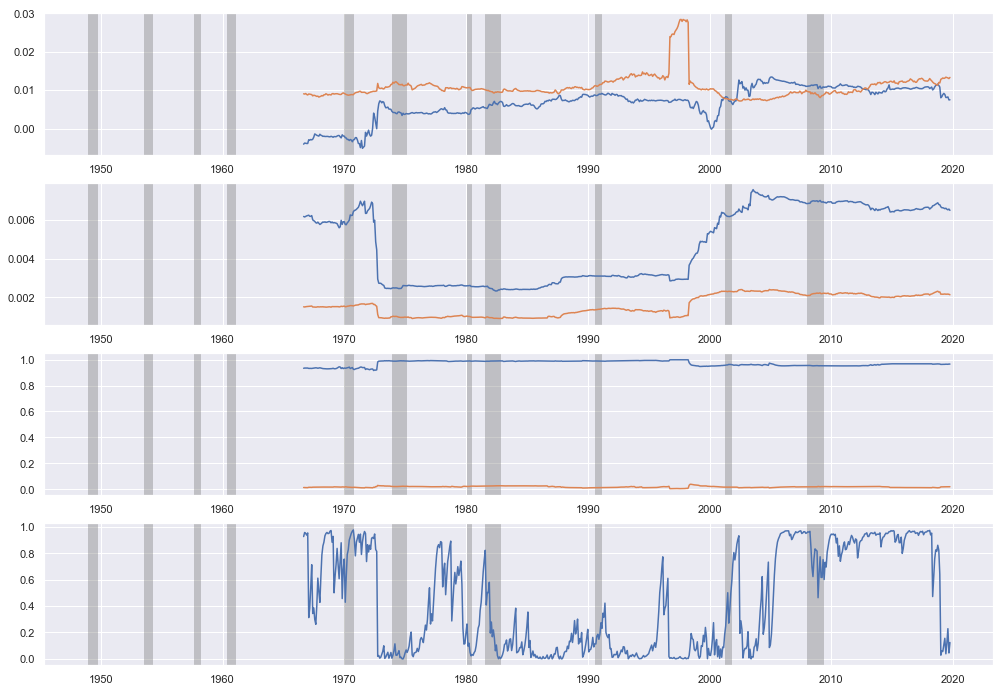

In [166]:
fix,axes = plt.subplots(4,1,figsize=[17,12])

ax = axes[0]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'mu_0'),(hmm_name,'mu_1')]]
d.index = d.index.get_level_values('Date')
ax.plot(d)

ax = axes[1]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'sigma2_0'),(hmm_name,'sigma2_1')]]
d.index = d.index.get_level_values('Date')
ax.plot(d)

ax = axes[2]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'p00'),(hmm_name,'p10')]]
d.index = d.index.get_level_values('Date')
ax.plot(d)

ax = axes[3]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
s = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'filt_prob_1')]]
s.index = s.index.get_level_values('Date')
ax.plot(s)

plt.show()